In [30]:
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

In [31]:
class ABENet(nn.Module):
    def __init__(self, N, has_key=True):
        super(ABENet, self).__init__()
        self.N = N
        
        self.fc    = nn.Linear(in_features=2*N if has_key else N, out_features=2*N)
        self.conv1 = nn.Conv1d(kernel_size=4, in_channels=1, out_channels=2, stride=1, padding=2)
        self.conv2 = nn.Conv1d(kernel_size=2, in_channels=2, out_channels=4, stride=2)
        self.conv3 = nn.Conv1d(kernel_size=1, in_channels=4, out_channels=4, stride=1)
        self.conv4 = nn.Conv1d(kernel_size=1, in_channels=4, out_channels=1, stride=1)

    def forward(self, x):
        x = torch.sigmoid( self.fc(x) )
        x = x.view(-1, 1, 2*self.N)
        x = torch.sigmoid( self.conv1(x) )
        x = torch.sigmoid( self.conv2(x) )
        x = torch.sigmoid( self.conv3(x) )
        x = torch.tanh(    self.conv4(x) )
        x = x.view(-1, self.N)
        return x

In [32]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda', index=0)

![symmetric_encryption](img/symmetric_enc.png)

In [59]:
N = 16 # [16, 32, 64]
minibatch_size = 4096 # [256..4096]

A = ABENet(N, has_key=True).to(DEVICE)
B = ABENet(N, has_key=True).to(DEVICE)
E = ABENet(N, has_key=False).to(DEVICE)

In [34]:
#l1_norm = lambda P1, P: torch.mean( torch.sum( torch.abs(P1 - P), dim=1 ), dim=0 ) # mean of batch
l1_norm = nn.L1Loss()
loss_eve = l1_norm
loss_bob = l1_norm
#loss_alicebob = lambda P_bob, P_eve, P: loss_bob(P_bob, P) + (((N/2 - loss_eve(P_eve, P))**2) / ((N/2)**2))
loss_alicebob = lambda P_bob, P_eve, P: loss_bob(P_bob, P) + (((1.0 - loss_eve(P_eve, P))**2))

In [35]:
def reconstruction_error(Out, Original):
    return torch.mean( torch.sum( torch.sign(Original) != torch.sign(Out), dim=1)
                       .to(torch.float), dim=0).item()

In [36]:
def gen_bitstring(N, batch_size=minibatch_size):
    return torch.randint(low=0, high=2, size=(batch_size,N), dtype=torch.float).to(DEVICE)*2-1

In [39]:
def train_abe(A, B, E,
              lr=0.0008,
              max_iter=150000,
              debug_print=1000,
              loss_eve=loss_eve,
              loss_alicebob=loss_alicebob,
              stop_condition=(lambda AB_loss, E_loss:
                              # AB_loss < 0.05 and E_loss > 2
                              AB_loss < 0.005 and E_loss > 0.5)):
    
    # Optimizers
    A_optimizer = optim.Adam(A.parameters(), lr=0.0008)
    B_optimizer = optim.Adam(B.parameters(), lr=0.0008)
    E_optimizer = optim.Adam(E.parameters(), lr=0.0008)

    ABs = [] # AB loss values
    Es  = [] # E loss values

    Rec_B = []
    Rec_E = []
    
    [X.train() for X in [A,B,E]] # Set models in training mode

    start_time = time.time()
    for ic in range(max_iter):
        # Train A/B for 1 minibtach and E for 2 minibatches to give it some advantage
        for who, num_minibatches in [('AB', 1), ('E', 2)]:
            for _ in range(num_minibatches):
                P = gen_bitstring(N, batch_size=minibatch_size)
                K = gen_bitstring(N, batch_size=minibatch_size) 

                C     = A(torch.cat((P, K), dim=1))
                P_bob = B(torch.cat((C, K), dim=1))
                P_eve = E(C)

                if who == 'AB':
                    A_optimizer.zero_grad()
                    B_optimizer.zero_grad()
                    AB_loss = loss_alicebob(P_bob, P_eve, P)
                
                    AB_loss.backward()
                    A_optimizer.step()
                    B_optimizer.step()
                
                elif who == 'E':
                    E_optimizer.zero_grad()
                    E_loss  = loss_eve(P_eve, P)
                    
                    E_loss.backward()
                    E_optimizer.step()

        if debug_print > 0 and ic % debug_print == (debug_print-1):
            elapsed_time = time.time() - start_time
            print("[{:6d}] AB_loss: {:2.4f} E_loss: {:2.4f} Elapsed Time: {}".format(
                ic+1, AB_loss, E_loss, time.strftime("%H:%M:%S", time.gmtime(elapsed_time))))

        Rec_B.append(reconstruction_error(P, P_bob))
        Rec_E.append(reconstruction_error(P, P_eve))
        ABs.append(AB_loss.item())
        Es.append(E_loss.item())

        if stop_condition(AB_loss, E_loss): # AB_loss < 0.05 and E_loss > 2
            break

    [X.train(False) for X in [A,B,E]]
    return ABs, Es, Rec_B, Rec_E

In [60]:
ABs, Es, RBs, ERs = train_abe(A,B,E, max_iter=15000)

[  1000] AB_loss: 0.9978 E_loss: 1.0001 Elapsed Time: 00:00:34


[  2000] AB_loss: 1.0021 E_loss: 0.9988 Elapsed Time: 00:01:08


[  3000] AB_loss: 0.9985 E_loss: 0.9962 Elapsed Time: 00:01:43


[  4000] AB_loss: 1.0017 E_loss: 0.9959 Elapsed Time: 00:02:17


[  5000] AB_loss: 0.9983 E_loss: 0.9991 Elapsed Time: 00:02:51


[  6000] AB_loss: 0.3513 E_loss: 0.8809 Elapsed Time: 00:03:26


[  7000] AB_loss: 0.0915 E_loss: 0.7746 Elapsed Time: 00:04:00


[  8000] AB_loss: 0.0348 E_loss: 0.8548 Elapsed Time: 00:04:35


[  9000] AB_loss: 0.0157 E_loss: 0.9039 Elapsed Time: 00:05:09


[ 10000] AB_loss: 0.0081 E_loss: 0.9326 Elapsed Time: 00:05:43


In [42]:
def plot_abe_losses(ABs, Es):
    plt.figure(figsize=(14,8))
    plt.plot(range(1, len(ABs)+1), ABs, label='Alice/Bob')
    plt.plot(range(1, len(Es)+1), Es, label='Eve')
    plt.xlabel("Iteration", fontsize=14)
    plt.ylabel("Loss", fontsize=14)
    plt.legend(fontsize=14)
    plt.grid(True, which='both')
    plt.show()

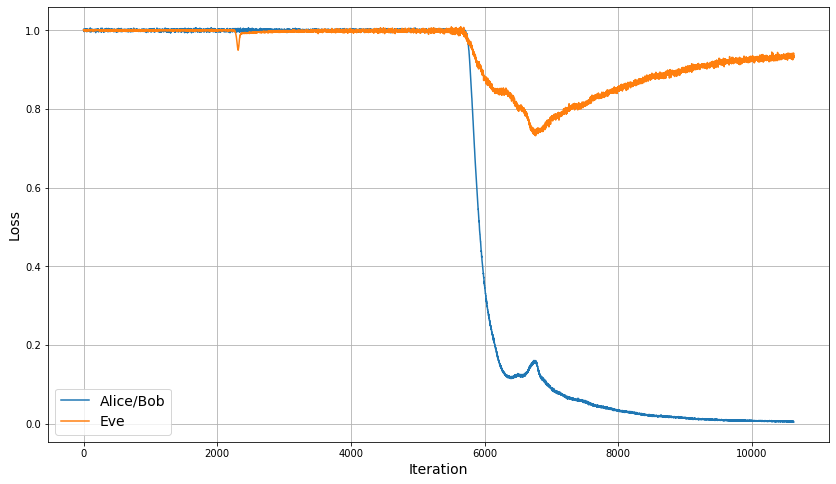

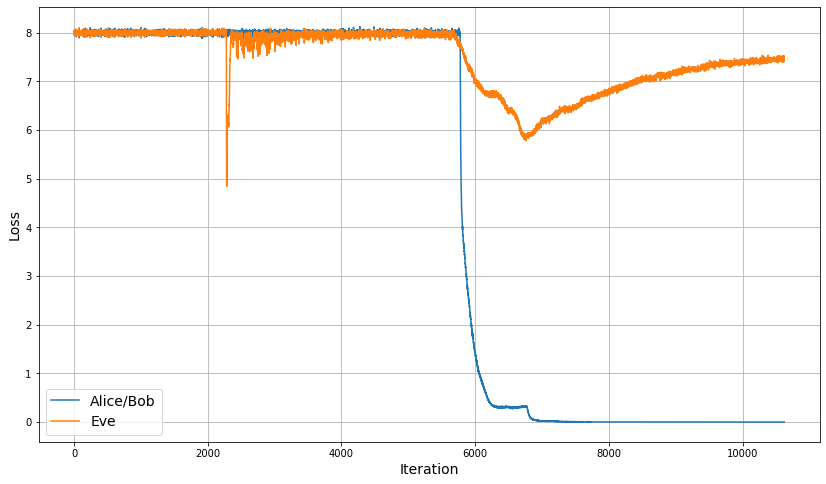

In [62]:
plot_abe_losses(ABs, Es)
plot_abe_losses(RBs, ERs)

In [63]:
def test_enc(A,B,E, debug=True):
    with torch.no_grad():
        P = gen_bitstring(N, batch_size=1)
        K = gen_bitstring(N, batch_size=1)
        C = A(torch.cat((P, K), dim=1))
        D = B(torch.cat((C, K), dim=1))
        F = E(C)
        if debug:
            print ("P:\n", P.cpu())
            print ("K:\n", K.cpu())
            print ("A(P,K):\n", C.cpu())
            print ("B(A(P, K), K):\n", D.cpu())
            print ("E(A(P, K)):\n", F.cpu())
        return P, K, C, D, F

In [64]:
_ = test_enc(A,B,E, debug=True)

P:
 tensor([[ 1., -1., -1., -1., -1.,  1.,  1.,  1., -1.,  1., -1.,  1.,  1., -1.,
          1., -1.]])
K:
 tensor([[-1., -1., -1.,  1.,  1., -1., -1., -1.,  1., -1.,  1.,  1.,  1., -1.,
         -1.,  1.]])
A(P,K):
 tensor([[ 0.4233, -0.5059,  0.2985,  0.5142, -0.3846, -0.6399,  0.3719, -0.4948,
          0.0283,  0.5310, -0.1722,  0.1630, -0.4858,  0.2891,  0.3848,  0.1223]])
B(A(P, K), K):
 tensor([[ 0.9997, -0.9977, -0.9991, -0.9976, -0.9976,  0.9991,  0.9998,  0.9996,
         -0.9964,  0.9962, -0.9976,  0.9999,  0.9997, -0.9966,  0.9988, -0.9979]])
E(A(P, K)):
 tensor([[-1.0000,  0.9960,  1.0000,  1.0000, -0.9992, -0.9999, -1.0000,  0.9271,
          1.0000,  1.0000, -1.0000, -0.9977,  0.9999, -1.0000, -1.0000, -0.9205]])


In [65]:
TEST_SIZE = 10000
B_correct = 0
E_correct = 0
        
for I in range(TEST_SIZE):
    P, K, C, P_b, P_e = test_enc(A,B,E, debug=False)
    if reconstruction_error(P, P_b) == 0: B_correct += 1
    if reconstruction_error(P, P_e) == 0: E_correct += 1
print ("B: {:.4f}".format(B_correct * 100 / TEST_SIZE))
print ("E: {:.4f}".format(E_correct * 100 / TEST_SIZE))


B: 100.0000
E: 0.0100


In [66]:
def train_best_eve(A, E,
                   max_iter=250000,
                   retries=5,
                   debug_print=10000):

    Best_E_loss = float("Inf")
    Best_E = None

    for es in range(retries):
        CE = ABENet(N, has_key=False).to(DEVICE)
        CE_optimizer = optim.Adam(CE.parameters(), lr=0.0008)
        CE.train()
        start_time = time.time()
        for ic in range(max_iter):
            P = gen_bitstring(N, batch_size=minibatch_size)
            K = gen_bitstring(N, batch_size=minibatch_size)
                   
            C       = A(torch.cat((P, K), dim=1))
            P_eve   = CE(C)
            CE_loss = loss_eve(P_eve, P)
            CE_optimizer.zero_grad()
            CE_loss.backward()
            CE_optimizer.step()

            if debug_print > 0 and ic % debug_print == (debug_print-1):
                elapsed_time = time.time() - start_time
                print("[{:d} - {:6d}] CE_loss: {:2.4f} Elapsed Time: {}".format(
                    es+1, ic+1, CE_loss, time.strftime("%H:%M:%S", time.gmtime(elapsed_time))))

            if CE_loss <= 0.05:
                raise RuntimeError("Optimal E found!")
                break
            
        if CE_loss.item() < Best_E_loss:
            Best_E_loss = CE_loss.item()
            Best_E = CE

    return Best_E, Best_E_loss

In [47]:
Best_E, Best_E_loss = train_best_eve(A, E, retries=3, max_iter=20000)
Best_E_loss

[1 -  10000] CE_loss: 0.8355 Elapsed Time: 00:03:00
[1 -  20000] CE_loss: 0.8413 Elapsed Time: 00:06:00
[2 -  10000] CE_loss: 0.8394 Elapsed Time: 00:03:01
[2 -  20000] CE_loss: 0.8285 Elapsed Time: 00:06:02
[3 -  10000] CE_loss: 0.8563 Elapsed Time: 00:03:00
[3 -  20000] CE_loss: 0.8573 Elapsed Time: 00:06:02


0.8285450339317322

In [58]:
# Train new A,B,E and validate them for 20 times
def validate(num_times=20):
    AB = []
    BE = []
    start_time = time.time()
    for n in range(num_times):
        A = ABENet(N, has_key=True).to(DEVICE)
        B = ABENet(N, has_key=True).to(DEVICE)
        E = ABENet(N, has_key=False).to(DEVICE)
        ABs, Es = train_abe(A,B,E, max_iter=15000, debug_print=5000)
        _, Best_E_loss = train_best_eve(A, E, retries=3, max_iter=15000, debug_print=7500)
        AB.append(ABs[-1])
        BE.append(Best_E_loss)
        elapsed_time = time.time() - start_time
        print("[N: {}] AB_loss: {:2.4f} E_loss: {:2.4f} Elapsed Time: {}".format(
            n+1, ABs[-1], Best_E_loss, time.strftime("%H:%M:%S", time.gmtime(elapsed_time))))

    return AB, BE


In [59]:
AB, BE = validate(num_times=5)

[  5000] AB_loss: 0.0713 E_loss: 0.9259 Elapsed Time: 00:02:50
[ 10000] AB_loss: 0.0625 E_loss: 0.9683 Elapsed Time: 00:05:40
[ 15000] AB_loss: 0.0630 E_loss: 0.9756 Elapsed Time: 00:08:30
[1 -   7500] CE_loss: 0.8873 Elapsed Time: 00:01:13
[1 -  15000] CE_loss: 0.8787 Elapsed Time: 00:02:36
[2 -   7500] CE_loss: 0.9276 Elapsed Time: 00:01:55
[2 -  15000] CE_loss: 0.9054 Elapsed Time: 00:03:31
[3 -   7500] CE_loss: 0.8815 Elapsed Time: 00:01:49
[3 -  15000] CE_loss: 0.8752 Elapsed Time: 00:03:41
[N: 1] AB_loss: 0.0630 E_loss: 0.8752 Elapsed Time: 00:18:19
[  5000] AB_loss: 0.0487 E_loss: 0.8300 Elapsed Time: 00:02:50
[1 -   7500] CE_loss: 0.8400 Elapsed Time: 00:01:55
[1 -  15000] CE_loss: 0.8486 Elapsed Time: 00:03:50
[2 -   7500] CE_loss: 0.8408 Elapsed Time: 00:01:55
[2 -  15000] CE_loss: 0.8393 Elapsed Time: 00:03:51
[3 -   7500] CE_loss: 0.8426 Elapsed Time: 00:01:19
[3 -  15000] CE_loss: 0.8432 Elapsed Time: 00:02:33
[N: 2] AB_loss: 0.0050 E_loss: 0.8393 Elapsed Time: 00:34:12
[ 

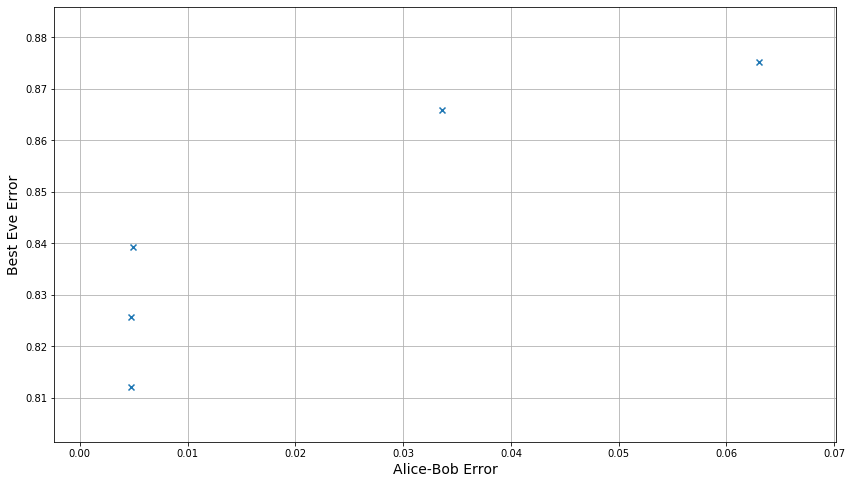

In [65]:
def plot_best_eves(AB, BE):
    plt.figure(figsize=(14,8))
    plt.scatter(AB,BE, marker='x')
    plt.xlabel("Alice-Bob Error", fontsize=14)
    plt.ylabel("Best Eve Error", fontsize=14)
    plt.grid(True, which='both')
    plt.show()

plot_best_eves(AB, BE)

In [40]:
# Paper Loss function with - sign
A_1 = ABENet(N, has_key=True).to(DEVICE)
B_1 = ABENet(N, has_key=True).to(DEVICE)
E_1 = ABENet(N, has_key=False).to(DEVICE)

l1_norm_1 = lambda P1, P: torch.mean( torch.sum( torch.abs(P1 - P), dim=1 ), dim=0 ) # mean of batch
loss_eve_1 = l1_norm_1
loss_bob_1 = l1_norm_1
loss_alicebob_1 = lambda P_bob, P_eve, P: loss_bob_1(P_bob, P) - (((N/2 - loss_eve_1(P_eve, P))**2) / ((N/2)**2))

ABs_1, Es_1, B_error, E_error = train_abe(A_1, B_1, E_1,
                        max_iter=10000, loss_eve=loss_eve_1, loss_alicebob=loss_alicebob_1)
#plot_abe_losses(ABs_1, Es_1)

[  1000] AB_loss: 14.9973 E_loss: 15.9751 Elapsed Time: 00:00:34


[  2000] AB_loss: -0.3831 E_loss: 0.2212 Elapsed Time: 00:01:08


[  3000] AB_loss: -0.8550 E_loss: 0.0268 Elapsed Time: 00:01:43


[  4000] AB_loss: -0.9352 E_loss: 0.0083 Elapsed Time: 00:02:17


[  5000] AB_loss: -0.9660 E_loss: 0.0030 Elapsed Time: 00:02:52


[  6000] AB_loss: -0.9809 E_loss: 0.0011 Elapsed Time: 00:03:26


[  7000] AB_loss: -0.9889 E_loss: 0.0004 Elapsed Time: 00:04:01


[  8000] AB_loss: -0.9934 E_loss: 0.0001 Elapsed Time: 00:04:36


[  9000] AB_loss: -0.9960 E_loss: 0.0001 Elapsed Time: 00:05:11


[ 10000] AB_loss: -0.9976 E_loss: 0.0000 Elapsed Time: 00:05:45


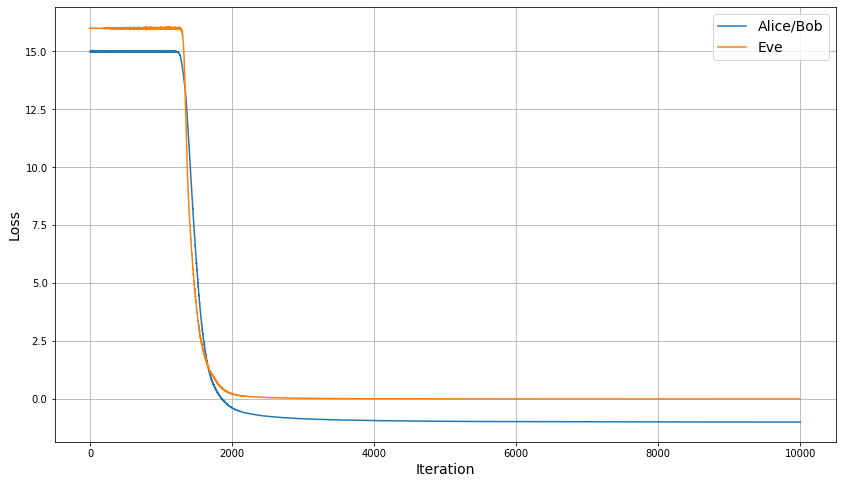

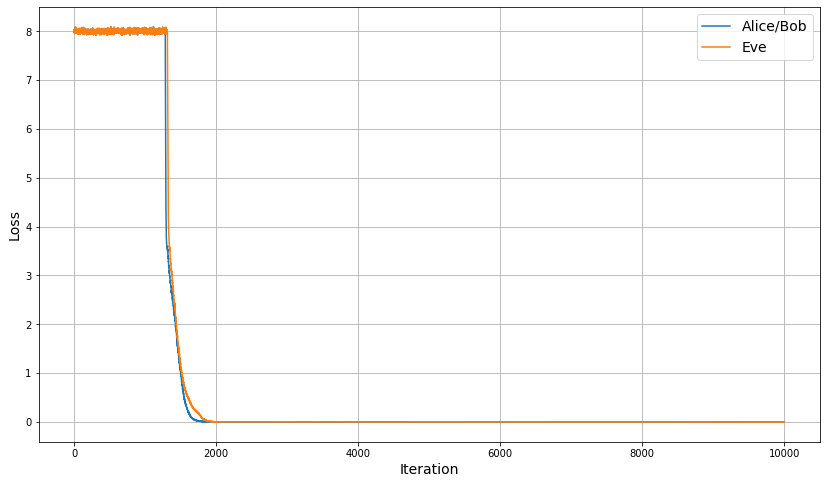

In [55]:
plot_abe_losses(ABs_1, Es_1)
plot_abe_losses(B_error, E_error)

[  1000] AB_loss: 5.7186 E_loss: 4.0736 Elapsed Time: 00:00:34


[  2000] AB_loss: 2.2708 E_loss: 4.5260 Elapsed Time: 00:01:09


[  3000] AB_loss: 1.8891 E_loss: 6.6428 Elapsed Time: 00:01:43


[  4000] AB_loss: 1.8267 E_loss: 7.4230 Elapsed Time: 00:02:18


[  5000] AB_loss: 1.5280 E_loss: 7.8007 Elapsed Time: 00:02:52


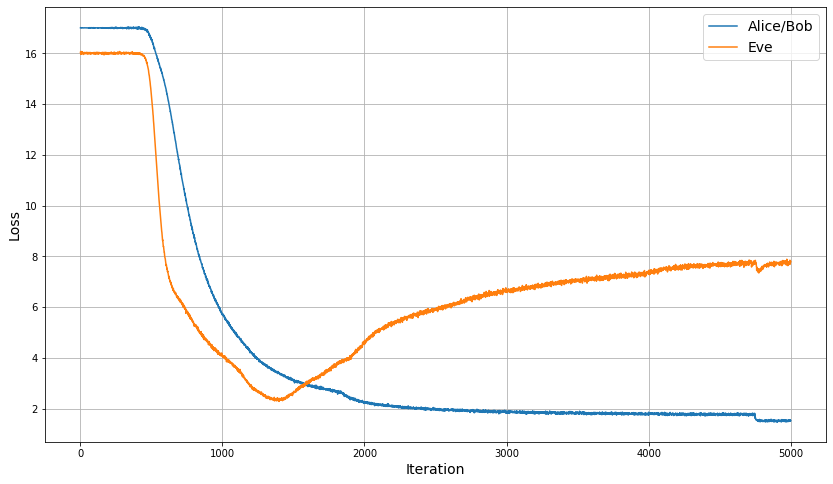

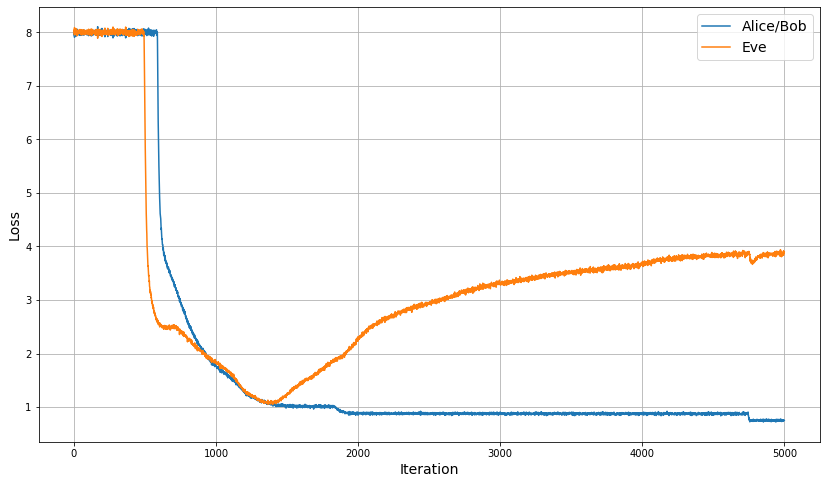

In [56]:
# Paper Loss function with + sign
A_2 = ABENet(N, has_key=True).to(DEVICE)
B_2 = ABENet(N, has_key=True).to(DEVICE)
E_2 = ABENet(N, has_key=False).to(DEVICE)

loss_alicebob_2 = lambda P_bob, P_eve, P: loss_bob_1(P_bob, P) + (((N/2 - loss_eve_1(P_eve, P))**2) / ((N/2)**2))

ABs_2, Es_2, B_error_2, E_error_2 = train_abe(A_2, B_2, E_2,
                        max_iter=5000, loss_eve=loss_eve_1, loss_alicebob=loss_alicebob_2,
                        stop_condition=(lambda AB_loss, E_loss:
                                        AB_loss < 0.05 and E_loss > 2))
plot_abe_losses(ABs_2, Es_2)
plot_abe_losses(B_error_2, E_error_2)